# Dynamic Topic Modeling Baseline Exercise

Goal: Create a clustering algorithm that shows the anatomy of each topic and how it has evolved over time.

Library: BERTopic. BERTopic is a topic modeling technique that leverages BERT embeddings and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions.

### Install new libraries

In [ ]:
! pip install bertopic

In [ ]:
! pip install bertopic[visualization]

### Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from bertopic import BERTopic
import nltk
import plotly.io as pio
pio.renderers.default = "svg"
import kaleido


/opt/homebrew/Caskroom/miniforge/base/envs/mle-week04/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Taken from this tutorial: [**Dynamic Topic Modeling with BERTopic**](https://towardsdatascience.com/dynamic-topic-modeling-with-bertopic-e5857e29f872)
We will drop business, sports and movies and start with technology and healthcare first. There are three main algorithm components:
1. Embed Documents: Extract document embeddings with *Sentence Transformers*. 
2. Cluster Documents: Create groups of similar documents with *UMAP* to reduce the dimensionaility of embeddings and HDBSCAN (to identify and cluster similar documents).
3. Create Topic Representation: Extract and reduce topics with c-TF-IDF (class-based term frequency, inverse document frequency).

Please note! The plots are interactive so will not display properly in github. I've converted them to static SVGs per this thread: https://github.com/MaartenGr/BERTopic/issues/226 

### Load data

In [2]:
# Load in the all-the-news dataset (25k news articles) into a pandas dataframe
df = pd.read_csv('./data/all-the-news-25k.csv')

In [3]:
df.head()

,date,year,month,day,title,article,section,publication
0,2018-05-02 17:09:00,2018,5.0,2,You Can Trick Your Brain Into Being More Focused,If only every day could be like this. You can’...,healthcare,Vice
1,2019-06-23 00:00:00,2019,6.0,23,Hudson's Bay's chairman's buyout bid pits reta...,(Reuters) - The success of Hudson’s Bay Co Exe...,business,Reuters
2,2018-12-28 00:00:00,2018,12.0,28,Wells Fargo to pay $575 million in settlement ...,NEW YORK (Reuters) - Wells Fargo & Co (WFC.N) ...,business,Reuters
3,2019-05-21 00:00:00,2019,5.0,21,Factbox: Investments by automakers in the U.S....,(Reuters) - Major automakers have announced a ...,business,Reuters
4,2019-02-05 00:00:00,2019,2.0,5,Exclusive: Britain's financial heartland unbow...,LONDON (Reuters) - Britain’s financial service...,business,Reuters


In [4]:
df.shape

(25000, 8)

In [5]:
# Drop business, movies, and sports sections
df = df.drop(df[df.section.isin(['business', 'movies', 'sports'])].index)
df.shape

(10000, 8)

In [6]:
# Reset the index
df = df.reset_index(drop=True)
df.head()

,date,year,month,day,title,article,section,publication
0,2018-05-02 17:09:00,2018,5.0,2,You Can Trick Your Brain Into Being More Focused,If only every day could be like this. You can’...,healthcare,Vice
1,2019-06-20 00:00:00,2019,6.0,20,"Hungary has no evidence of Huawei threat, plan...",BUDAPEST (Reuters) - Hungary has no evidence t...,technology,Reuters
2,2019-06-20 00:00:00,2019,6.0,20,Philippines' Globe Telecoms launches 5G servic...,MANILA (Reuters) - Philippines’ Globe Telecom ...,technology,Reuters
3,2018-10-08 00:00:00,2018,10.0,8,Google welcomes UK court block on claim over d...,(Reuters) - Google welcomed a decision on Mond...,technology,Reuters
4,2019-06-28 00:00:00,2019,6.0,28,"Google announces new subsea cable 'Equiano', c...",(Reuters) - Alphabet Inc’s Google on Friday an...,technology,Reuters


### Preprocess data

In [7]:
# Prepare to remove stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/curtispond/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Remove stop words
stop = stopwords.words('english')

df['article'] = df['article'].map(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [11]:
# Remove whitespace, punctuation, numbers, and lowercase all titles
def clean_text(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # remove punctuation
    text = re.sub('\w*\d\w*', '', text) # remove numbers
    text = text.strip() # remove whitespace
    text = text.lower() # lowercase
    return text # return cleaned text

In [12]:
# Apply the cleaning function to the title column
df['article'] = df['article'].apply(lambda x: clean_text(x))

In [13]:
# Inspect one of the cleaned titles
df['article'][0]

'if every day could like this you can’t put finger why maybe right amount sleep maybe stars somehow aligned favor whatever reason you’re cooking gas hours fly like minutes you’re feeling great know it’s  pm todo list done this feeling ‘flow’ ‘in zone’ something us experienced point other—although often might like it’s mental state elite athletes seem beck call for us mere mortals though hardly ever shows need it since psychologist mihály csíkszentmihályi first described zone which called ‘flow’  neuroscientists trying figure make show demand yet close secrets zone another truth emerged what think zone actually one many mental states person in works particular kind thinking here’s master one them several the flow zoneto understand states might work better makes sense first consider know this original ‘zone one thing definitely know feels great csíkszentmihályi describes ‘optimal experience’ achieve true happiness one explanation happens—and feels good—is represents perfect match activit

### Prepare data

In [14]:
articles = df.article.to_list()
dates = df.date.to_list()

### Create the model

In [15]:
# Create a BERTopic model
topic_model = BERTopic(verbose=True)
topics, probs = topic_model.fit_transform(articles)

Batches: 100%|██████████| 313/313 [02:37<00:00,  1.99it/s]
2022-12-23 17:39:52,616 - BERTopic - Transformed documents to Embeddings
2022-12-23 17:40:03,771 - BERTopic - Reduced dimensionality
2022-12-23 17:40:03,977 - BERTopic - Clustered reduced embeddings


#### Extract the largest 10 topics based on the number of topics assigned to each topic

In [16]:
freq = topic_model.get_topic_info()
freq.head(10)

,Topic,Count,Name
0,-1,3175,-1_people_the_says_like
1,0,244,0_fitbit_watch_smartwatch_fitness
2,1,201,1_opioid_drug_addiction_overdose
3,2,167,2_headphones_earbuds_wireless_headphone
4,3,167,3_insurance_bill_healthcare_health
5,4,165,4_drone_drones_dji_flight
6,5,130,5_vr_oculus_virtual_headset
7,6,123,6_selfdriving_cars_autonomous_vehicles
8,7,111,7_euros_million_versus_eikon
9,8,109,8_phone_samsung_galaxy_phones


Topic -1 is a topic consisting of outlier documents that are typically ignored due to their prevalence aross the whole corpus and not any particular topic.

In [17]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,3175,-1_people_the_says_like
1,0,244,0_fitbit_watch_smartwatch_fitness
2,1,201,1_opioid_drug_addiction_overdose
3,2,167,2_headphones_earbuds_wireless_headphone
4,3,167,3_insurance_bill_healthcare_health
...,...,...,...
176,175,11,175_goop_hermes_naturopathic_powder
177,176,11,176_wonshare_bonds_convertible_korean
178,177,11,177_twitter_characters_tweets_tweet
179,178,10,178_water_hydrogen_spring_vreeman


In [18]:
# Look at the terms that contribute to a topic
topic_nr = freq.iloc[5]["Topic"] # select a frequent topic
topic_model.get_topic(topic_nr)

[('drone', 0.06474730759644962),
 ('drones', 0.049233821221366214),
 ('dji', 0.026648655297029904),
 ('flight', 0.01395097385981641),
 ('delivery', 0.011757746738779168),
 ('aircraft', 0.01149980167740854),
 ('fly', 0.010910693465072162),
 ('camera', 0.009885450710168562),
 ('flying', 0.009855524483225664),
 ('djis', 0.008564896766271323)]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


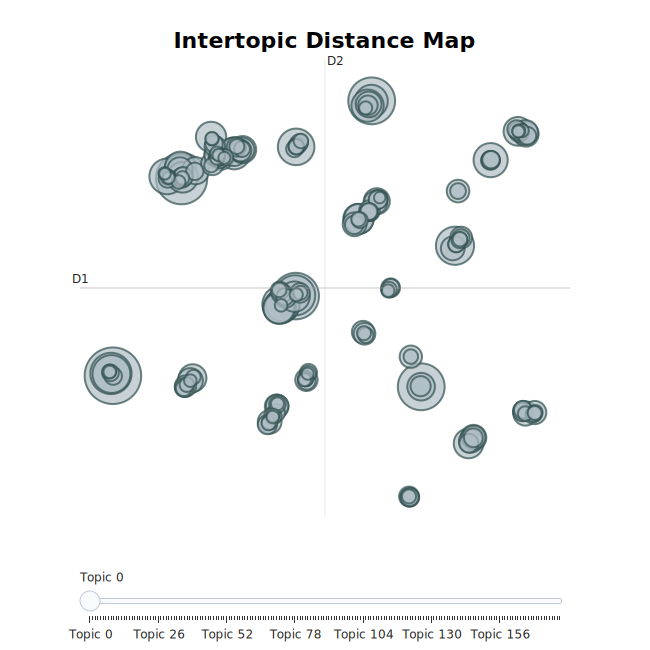

In [19]:
# Visualize the topics
topic_model.visualize_topics()

Each circle indicates a topic and its size is the frequency of the topic across all documents. It's interesting to play around with the slider. You can see where topics overlap. For example, Topic 6 contains VR, Oculus, Virtual, Headset and Vive. Topic 160, which is a red circle above Topic 6 when you move the slider to the right, contains spectacles, glasses, snapchat, lenses, and sunglasses.

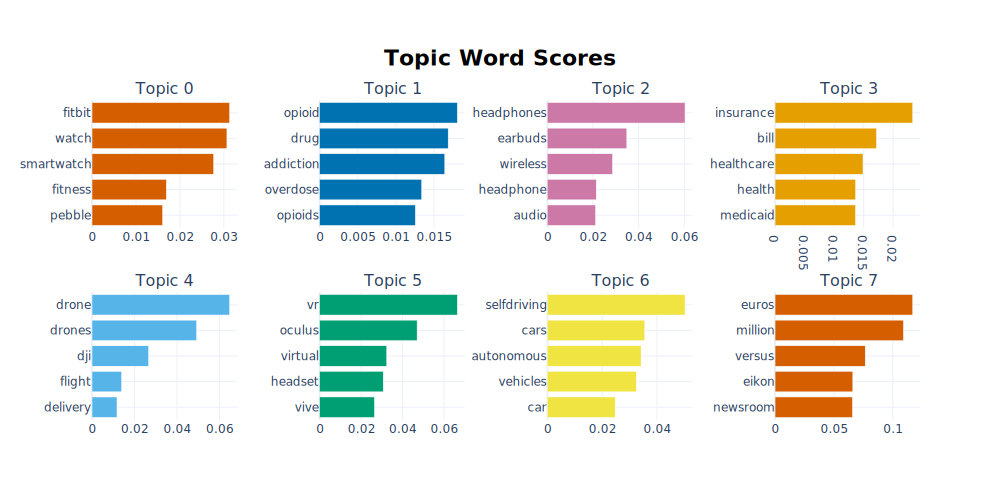

In [20]:
# Visualize the topics in a bar chart
topic_model.visualize_barchart()

100%|██████████| 179/179 [00:00<00:00, 288.06it/s]


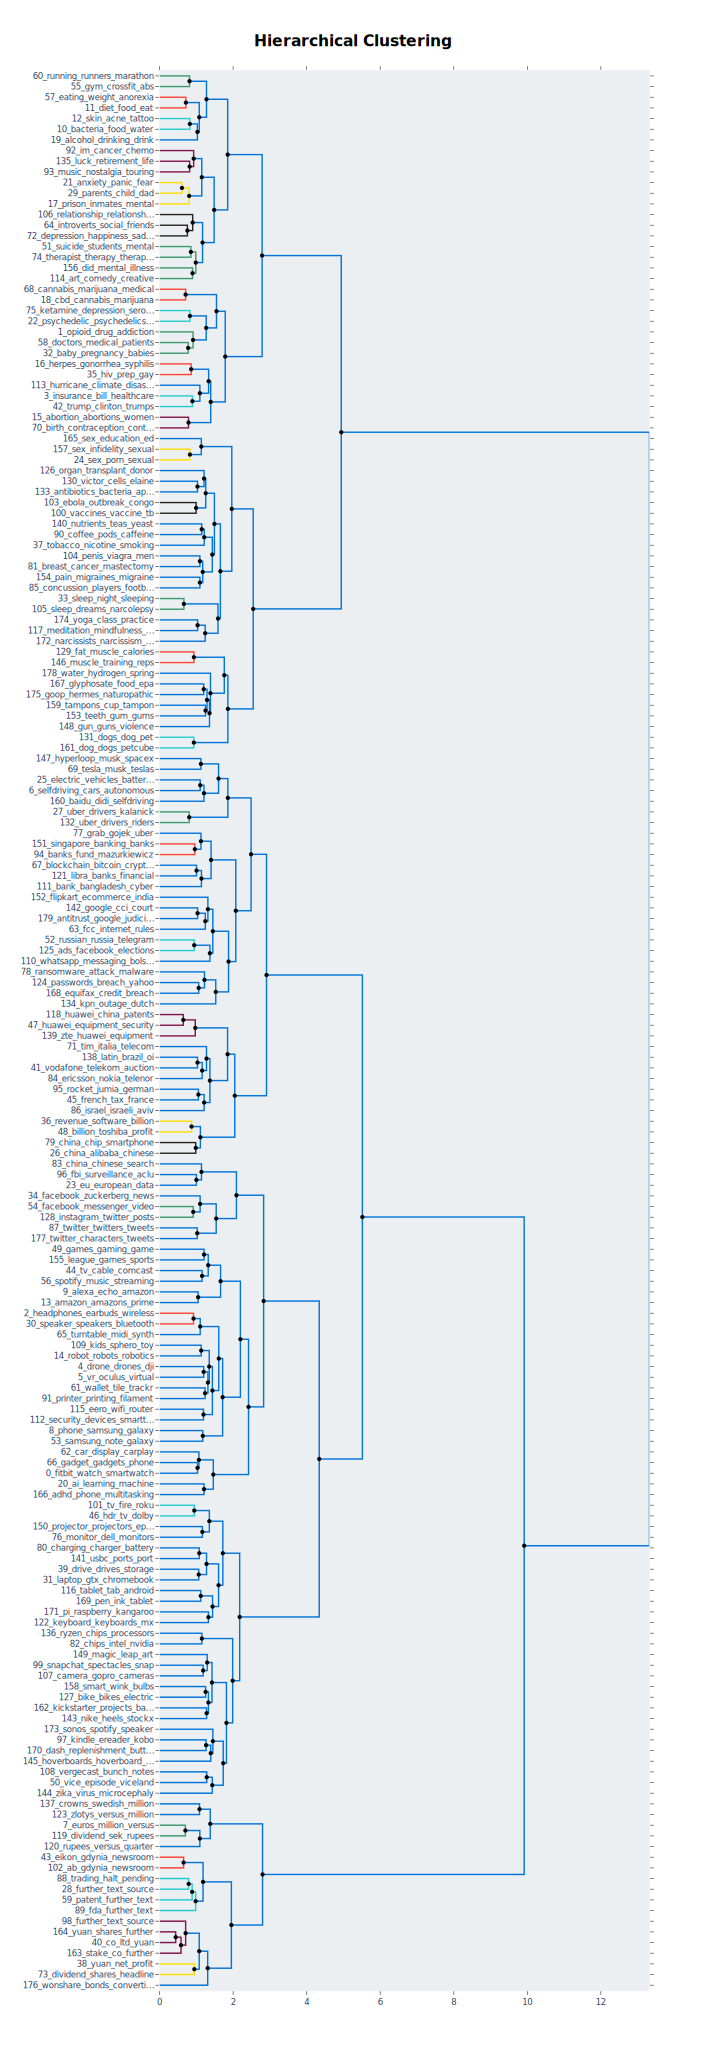

In [21]:
hierarchical_topics = topic_model.hierarchical_topics(articles)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

I think this visualization is a little challenging to digest, but it looks like it's building a relationship between all 180 topics.

In [22]:
# Visualize the topics over time
topics_over_time = topic_model.topics_over_time(articles, dates)

4938it [04:37, 17.81it/s]


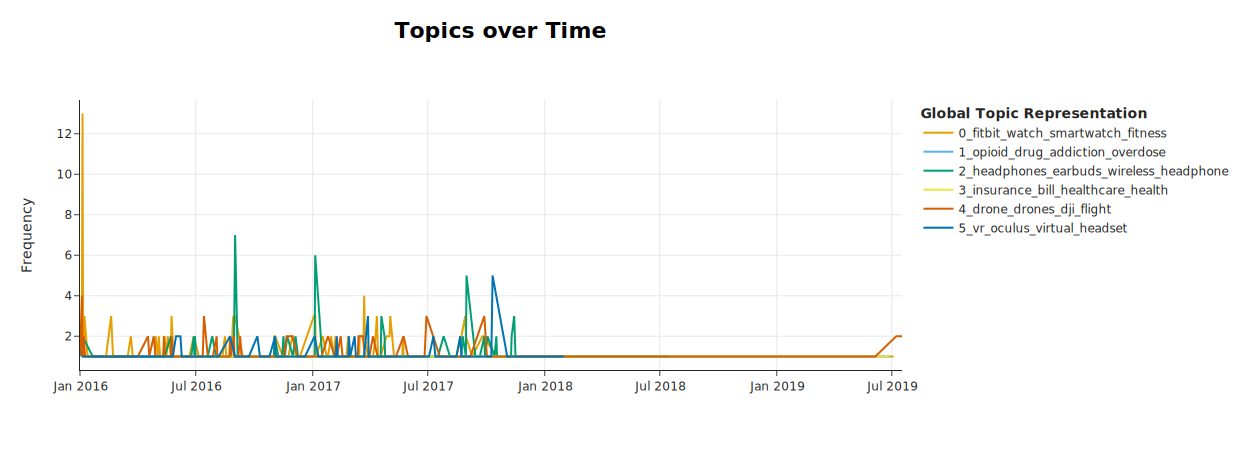

In [23]:
topic_model.visualize_topics_over_time(topics_over_time, topics=[0, 1, 2, 3, 4, 5])

I can see value in the Topics over Time output, but only if we're working with recent data. For example, you can show GLG how certain topics are spiking to possibly indicate that GLG will get incoming client requests related to similar topics. This can help GLG to anticipate the need for adequate SME resources so they can fulfill client requests in a timely manner.